# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.938991,False,-0.530803
1,-0.384510,True,3.778493
2,-1.970561,False,-2.886515
3,-0.419524,True,3.200540
4,-0.318488,False,-1.393982
...,...,...,...
995,-1.465312,False,-3.578865
996,-0.001051,False,-0.937668
997,0.589328,True,6.852108
998,-1.430820,False,-3.514041


<AxesSubplot:xlabel='v0'>

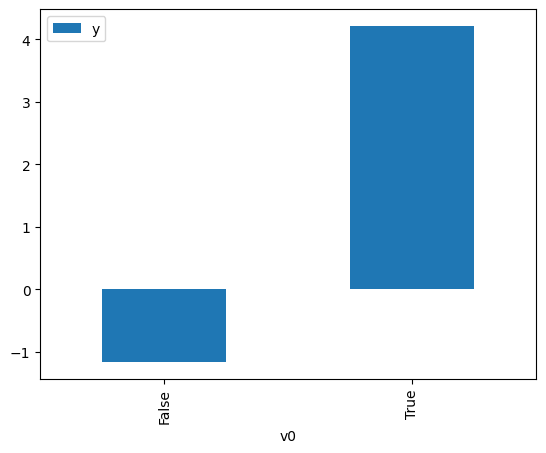

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

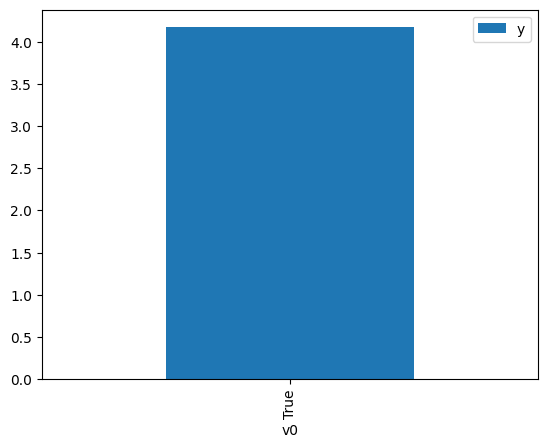

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.957618,False,-1.661931,0.858353,1.165022
1,-1.337269,False,-1.984218,0.920246,1.086667
2,-2.350020,False,-5.203337,0.984687,1.015551
3,-1.199212,False,0.256079,0.901277,1.109536
4,-2.150552,False,-3.556233,0.978653,1.021812
...,...,...,...,...,...
995,-1.940980,False,-1.592219,0.969815,1.031124
996,-0.708231,False,0.567268,0.798772,1.251921
997,-1.661728,False,-1.820832,0.952396,1.049983
998,-0.594715,False,0.178311,0.766039,1.305416


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-1.687627,True,1.563862,0.045651,21.905369
1,1.049106,True,5.984378,0.832349,1.201419
2,-0.665308,True,3.971974,0.213186,4.690742
3,-0.896282,True,3.149537,0.154775,6.461007
4,-0.926165,True,3.131752,0.148259,6.744967
...,...,...,...,...,...
995,0.110133,True,5.452158,0.502392,1.990478
996,-1.822805,True,4.073160,0.036639,27.293245
997,-0.703548,True,5.809752,0.202508,4.938085
998,-0.887379,True,5.124439,0.156761,6.379153


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.903
Model:                            OLS   Adj. R-squared (uncentered):              0.902
Method:                 Least Squares   F-statistic:                              4625.
Date:                Mon, 22 Aug 2022   Prob (F-statistic):                        0.00
Time:                        05:50:11   Log-Likelihood:                         -1395.4
No. Observations:                1000   AIC:                                      2795.
Df Residuals:                     998   BIC:                                      2805.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.2797      0.023     54.966      0.000       1.234       1.325
x2             5.0605      0.064     79.340      0.000       4.935       5.186
==============================================================================
Omnibus:                        0.522   Durbin-Watson:                   2.081
Prob(Omnibus):                  0.770   Jarque-Bera (JB):                0.571
Skew:                          -0.053   Prob(JB):                        0.752
Kurtosis:                       2.950   Cond. No.                         2.74
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""